<a href="https://colab.research.google.com/github/Sreeyakrishna/spotify-playlist-segmentation/blob/main/spotify_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Data Loading & Cleaning

import pandas as pd
import numpy as np
import zipfile
from google.colab import files

# Author: PT Sreeyakrishna

uploaded = files.upload()

with zipfile.ZipFile("Project 2  - Spotify Songs’ Genre Segmentation (1) (1) (1).zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Load dataset (adjust filename if different)
df = pd.read_csv("spotify dataset.csv")

# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Select relevant features
features = df[['danceability', 'energy', 'loudness', 'speechiness',
               'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

print("Shape after cleaning:", features.shape)


Saving Project 2  - Spotify Songs’ Genre Segmentation (1) (1) (1).zip to Project 2  - Spotify Songs’ Genre Segmentation (1) (1) (1).zip
Shape after cleaning: (32828, 9)


In [2]:
# Building Similarity Matrix

from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(features)

print("Similarity Matrix Shape:", similarity_matrix.shape)


Similarity Matrix Shape: (32828, 32828)


In [8]:
# User Collaborative Filtering

import numpy as np

# Example: Function to get top-N similar songs
def get_similar_songs(song_index, top_n=5):
    # Get similarity scores for given song
    sim_scores = list(enumerate(similarity_matrix[song_index]))
    # Sort by similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Skip first (self match) and take top_n
    top_similar = sim_scores[1:top_n+1]
    return [(df.iloc[i]['track_name'], df.iloc[i]['track_artist'], score) for i, score in top_similar]

# Example usage:
print("Similar Songs to first track:")
print(get_similar_songs(0, top_n=5))

Similar Songs to first track:
[("I Don't Care (with Justin Bieber) - Loud Luxury Remix", 'Ed Sheeran', np.float64(1.0000000000000002)), ("As If It's Your Last", 'BLACKPINK', np.float64(0.9999994827387733)), ('Rise - TV Noise Ibiza Mix', 'Jonas Blue', np.float64(0.9999993772181303)), ('Love With Your Life (Capital Kings Remix)', 'Hollyn', np.float64(0.9999993335392866)), ('You and I', 'Wahlstedt', np.float64(0.9999990836667413))]


In [6]:
# Hybrid Model (KMeans + Similarity)

from sklearn.cluster import KMeans

# Apply clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10) # Added n_init for robustness
df['Cluster'] = kmeans.fit_predict(features)

# Create a mapping from original df index to features index
index_mapping = {original_index: new_index for new_index, original_index in enumerate(features.index)}

# Hybrid Recommendation Function
def hybrid_recommend(song_index, top_n=5):
    cluster_id = df.iloc[song_index]['Cluster']
    cluster_songs_original_indices = df[df['Cluster'] == cluster_id].index.tolist()

    # Filter out indices that are not in the features DataFrame and map to new indices
    cluster_songs_features_indices = [
        index_mapping[i] for i in cluster_songs_original_indices
        if i in index_mapping and i != song_index # Ensure the song itself is not included
    ]

    # Get similarity scores for songs in the cluster
    sim_scores = [(original_index, similarity_matrix[index_mapping[song_index]][index_mapping[original_index]])
                  for original_index in cluster_songs_original_indices
                  if original_index in index_mapping and original_index != song_index] # Ensure the song itself is not included

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return [(df.iloc[i]['track_name'], score) for i, score in sim_scores]

# Example usage:
print("Hybrid Recommendations for first track:")
print(hybrid_recommend(0, top_n=5))

Hybrid Recommendations for first track:
[('Tequila - Robin Schulz Remix', np.float64(1.0000000000000002)), ("As If It's Your Last", np.float64(0.9999994827387733)), ('Sick Boy - Owen Norton Remix', np.float64(0.9999993772181303)), ('I Feel so Alive', np.float64(0.9999993335392866)), ('Made For You', np.float64(0.9999990836667413))]


🔹 Top 5 Similar Songs to: Cross Me (feat. Chance the Rapper & PnB Rock) - M-22 Remix by Ed Sheeran
                                          Track Name          Artist  \
0  Music Has the Power - Wolfgang Lohr Remix Radi...        !deladap   
1  Music Has the Power - Wolfgang Lohr Remix Radi...        !deladap   
2                                              Sunny        Boney M.   
3                                            Because         オメガトライブ   
4                             1-2-3 - Single Version  Gloria Estefan   

   Similarity Score  
0          0.999999  
1          0.999999  
2          0.999999  
3          0.999999  
4          0.999998  


/tmp/ipython-input-1548527630.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Similarity Score", y="Track Name", palette="viridis")


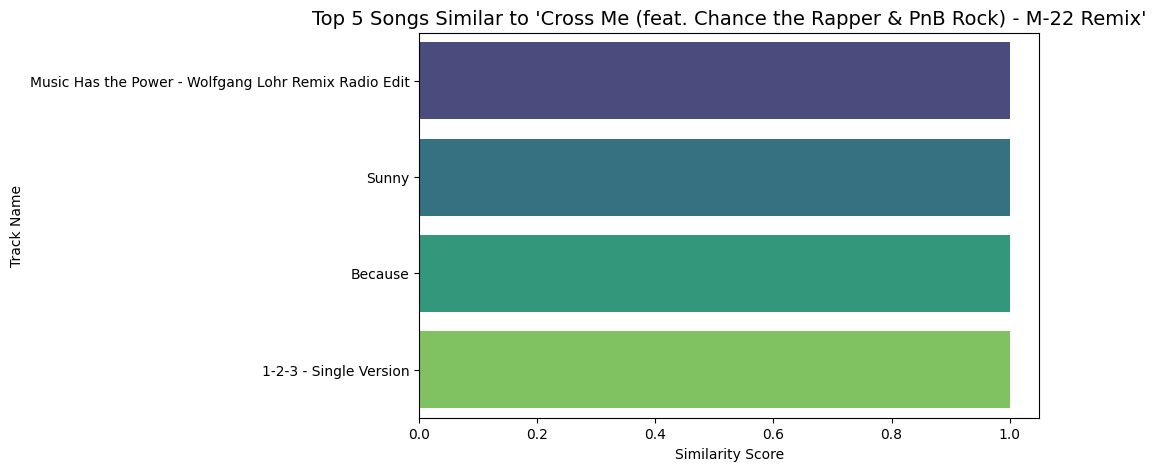

In [11]:
# --- Visualization (Table + Chart) ---

import matplotlib.pyplot as plt
import seaborn as sns

# Pick a sample song
sample_song_index = 10  # change index to test different songs
similar_songs = get_similar_songs(sample_song_index, top_n=5)

# Convert to DataFrame for table view
results_df = pd.DataFrame(similar_songs, columns=["Track Name", "Artist", "Similarity Score"])
print("🔹 Top 5 Similar Songs to:", df.iloc[sample_song_index]['track_name'], "by", df.iloc[sample_song_index]['track_artist'])
print(results_df)

# --- Bar Chart Visualization ---
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Similarity Score", y="Track Name", palette="viridis")
plt.title(f"Top 5 Songs Similar to '{df.iloc[sample_song_index]['track_name']}'", fontsize=14)
plt.xlabel("Similarity Score")
plt.ylabel("Track Name")
plt.show()